In [1]:
import numpy as np
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import welch
from scipy.signal.windows import hamming, hann
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('./nikhils_plot_style.mplstyle')

Johnson noise PSD for 1 kOhm resistor at 300 K is 1.6567782239999996e-17 V^2/Hz
Sampling frequency is 10000.0 Hz
Et = 0.026462678670054203 & Ek = 0.032041854399070015


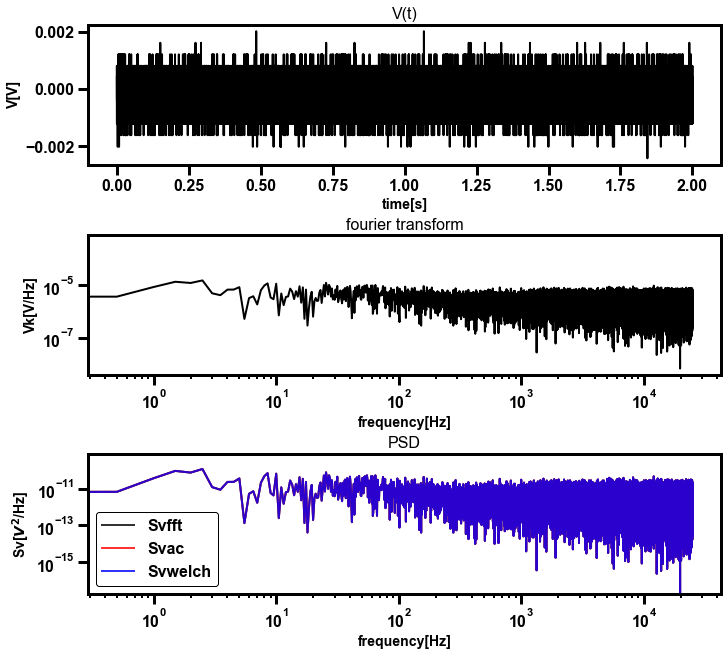

Svfft:
max=1.1158559989279205e-07	min=2.138455988219143e-17
Svwelch:
max=1.1764261268971894e-10	min=2.1384559882191698e-17
Svac:
max=1.1158559989279201e-07	min=2.1384559859198794e-17
##################################################
sum of Svfft = 3.204185439907001e-07
sum of Svwelch = 2.0883398675414602e-07
sum of Svac = 3.2041854399070134e-07
Median noise between 1 KHz and 10 KHz is 2.8650679609230695e-12 V^2/Hz


In [2]:
######################################################################################
def johnson_noise_psd(T, R):
    k = 1.38064852e-23 # Boltzmann constant in J/K
    return 4*k*T*R
print(f"Johnson noise PSD for 1 kOhm resistor at 300 K is {johnson_noise_psd(300, 1e3)} V^2/Hz")
#######################Simulated signal#######################################
dt = 0.0001 # time step in s
T = 2 # total time in s
fs = int(1/dt) # sampling frequency in Hz
N = int(T/dt) #number of points
time = np.arange(0,T,dt) # time in seconds
print(f"Sampling frequency is {1/dt} Hz")

fnoise_1 = 50 # noise frequency in Hz
Anoise_1 = 1 # noise amplitude

fnoise_2 = 120 # noise frequency in Hz
Anoise_2 = 0.7 # noise amplitude

V = Anoise_1*np.sin(2*np.pi* fnoise_1* time) + Anoise_2*np.sin(2*np.pi* fnoise_2* time)
######################################################################################
############### Signal from oscilloscope##############################################
######################################################################################

# fp="./data/scope_7_1.csv"# wire connected to the function generator
fp="./data/scope_13_1.csv"# 1 kOhm, time = 2 s
# fp="./data/scope_1.csv"# 100 KHz from function generator

df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

T = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
fs = int(N/T) # Hz
dt = 1/fs
time = df["time"].to_numpy() - df["time"].min()

V = df["voltage"].to_numpy()
#########################################################################################


#Discrete Fourier transform of V
Vk = np.absolute(fftshift(fft(V)))
Vk = 2*Vk[Vk.size//2:] # folding and only selecting positive frequencies
Vk = Vk/N # normalizing
fk = fftfreq(N,dt)
fk = fk[:fk.size//2]

# Energy calculation
Et = np.sum(np.absolute(V)**2)
Ek = np.sum(np.absolute(Vk)**2)*(N/2)

print(f"Et = {Et} & Ek = {Ek}")

#PSD from FFT
Svfft = (1/2)*np.absolute(Vk)**2

#PSD from welch
fwelch, Svwelch = welch(V, fs=fs, window='boxcar', nperseg=N, noverlap=0, return_onesided=True, scaling='density', axis=-1)
Svwelch = (1/2)*Svwelch

# PSD from autocorrelation
def correlation_nik_vectorized(V1, V2):
    assert V1.size==V2.size
    n = V1.size
    lags = list(range(0,n,1))
    V2doubled = np.concatenate((V2,V2))
    cor = np.zeros(n)
    for lag in lags:
        cor[lag] = V1.dot(V2doubled[lag:lag+n])
    cor = cor/n
    return cor


ac = correlation_nik_vectorized(V,V)
Svac = np.absolute(fftshift(fft(ac)))
Svac = Svac[Svac.size//2:]
Svac = Svac/fs

#plot
fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize=(10,9), constrained_layout=True)

ax1.plot(time, V)
ax1.set_xlabel("time[s]")
ax1.set_ylabel("V[V]")
ax1.set_title("V(t)")

ax2.plot(fk, Vk)
ax2.set_xlabel("frequency[Hz]")
ax2.set_ylabel("Vk[V/Hz]")
ax2.set_title("fourier transform")
ax2.set_xscale('log')
ax2.set_yscale('log')


ax3.plot(fk, Svfft, alpha=0.8, label = "Svfft")
ax3.plot(fk, Svac, alpha=0.8, label = "Svac")
ax3.plot(fwelch, Svwelch, alpha=0.8, label = "Svwelch")
ax3.set_xlabel("frequency[Hz]")
ax3.set_ylabel("Sv[$V^2$/Hz]")
ax3.set_title("PSD")
ax3.set_ylim(Svwelch[10:].min()*0.9,Svwelch[10:].max()*10)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend()

plt.show()

print(f"Svfft:\nmax={(Svfft.max())}\tmin={(Svfft[10:].min())}")
print(f"Svwelch:\nmax={(Svwelch.max())}\tmin={(Svwelch[10:].min())}")
print(f"Svac:\nmax={(Svac.max())}\tmin={(Svac[10:].min())}")
print(50*'#')
print(f"sum of Svfft = {np.sum(Svfft)}")
print(f"sum of Svwelch = {np.sum(Svwelch)}")
print(f"sum of Svac = {np.sum(Svac)}")

print(f"Median noise between 1 KHz and 10 KHz is {np.median(Svwelch[np.where((fwelch>1000) & (fwelch<10000))])} V^2/Hz")